<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_withse_50epoch_32batch_apple_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 27.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)#32
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)#64
parser.add_argument("--nch_d", type = int, default=64)#64
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        #self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        self.file_list = glob.glob("/content/drive/MyDrive/Test/Apple**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(70),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
       # b, c, h, w = x.size()
        x = self.conv1(x) 


      #  x = self.linear_1(x).view(b, -1, h, w)
        x = self.relu(x)
       # x = self.linear_2(x).view(b, -1, h, w)


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 67/67 [14:57<00:00, 13.39s/it]


epoch: 0, lossD:1.2338728971445738, lossG:5.384189808546608,lossG_fake:2.261870725830989, lossG_real:3.1223191289759393 ,equality:-0.8604484031449502


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:43.26791000366211,kid_mean:0.016042018309235573, kid_std:0.006346439011394978,kid_:(tensor(0.0160), tensor(0.0063))


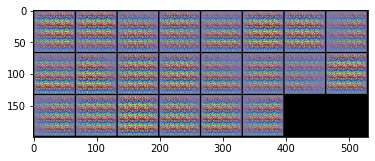

100%|██████████| 67/67 [00:24<00:00,  2.71it/s]


epoch: 1, lossD:0.41060321766938734, lossG:5.691718692210183,lossG_fake:2.354247379658827, lossG_real:3.337471314330599 ,equality:-0.9832239346717722


evaluate:35.74198913574219,kid_mean:0.01554760430008173, kid_std:0.008750553242862225,kid_:(tensor(0.0155), tensor(0.0088))


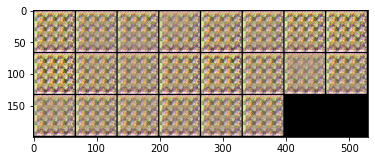

100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


epoch: 2, lossD:0.6156528743345346, lossG:5.429504750379875,lossG_fake:2.8343229471747553, lossG_real:2.5951817693995007 ,equality:0.23914117777525457


evaluate:44.97891616821289,kid_mean:0.023684971034526825, kid_std:0.014170315116643906,kid_:(tensor(0.0237), tensor(0.0142))


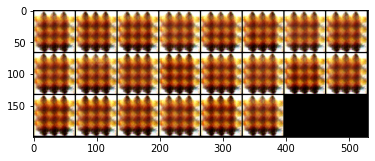

100%|██████████| 67/67 [00:25<00:00,  2.60it/s]


epoch: 3, lossD:0.961198754275023, lossG:4.32545785049894,lossG_fake:2.277269722810432, lossG_real:2.048188129467751 ,equality:0.22908159334268108


evaluate:41.31167221069336,kid_mean:0.021624615415930748, kid_std:0.011039347387850285,kid_:(tensor(0.0216), tensor(0.0110))


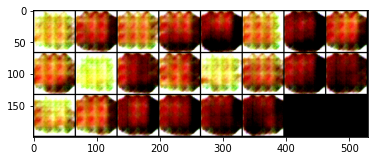

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 4, lossD:1.0059457812736283, lossG:3.659666111220175,lossG_fake:1.931487103006733, lossG_real:1.7281790171096574 ,equality:0.20330808589707572


evaluate:47.669342041015625,kid_mean:0.026951253414154053, kid_std:0.014162570238113403,kid_:(tensor(0.0270), tensor(0.0142))


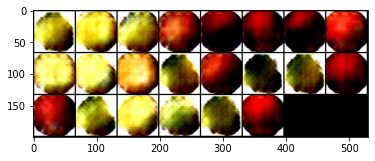

100%|██████████| 67/67 [00:26<00:00,  2.56it/s]


epoch: 5, lossD:1.4189261340383272, lossG:3.143837505312108,lossG_fake:1.6757247554722117, lossG_real:1.4681127471710318 ,equality:0.20761200830117987


evaluate:44.5388069152832,kid_mean:0.024274185299873352, kid_std:0.015228104777634144,kid_:(tensor(0.0243), tensor(0.0152))


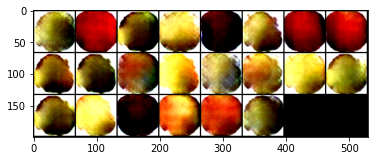

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 6, lossD:1.400114643039988, lossG:3.069278432362115,lossG_fake:1.64775283567941, lossG_real:1.4215255984619481 ,equality:0.22622723721746185


evaluate:41.9859504699707,kid_mean:0.02387143298983574, kid_std:0.013904186896979809,kid_:(tensor(0.0239), tensor(0.0139))


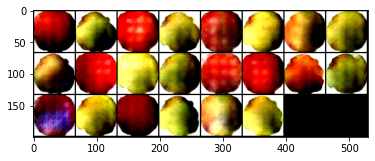

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 7, lossD:1.5151771520500752, lossG:3.0711542136633576,lossG_fake:1.670265801806948, lossG_real:1.4008884047394368 ,equality:0.2693773970675113


evaluate:40.91387176513672,kid_mean:0.019748440012335777, kid_std:0.011889546178281307,kid_:(tensor(0.0197), tensor(0.0119))


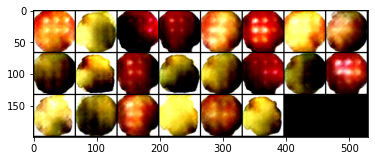

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 8, lossD:1.4342867296133468, lossG:3.127890209653484,lossG_fake:1.6699483252283354, lossG_real:1.4579418857595814 ,equality:0.21200643946875397


evaluate:40.91868591308594,kid_mean:0.021097473800182343, kid_std:0.012312867678701878,kid_:(tensor(0.0211), tensor(0.0123))


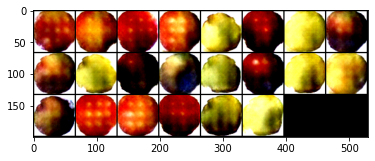

100%|██████████| 67/67 [00:26<00:00,  2.58it/s]


epoch: 9, lossD:1.4226175253071003, lossG:3.1829602896277582,lossG_fake:1.6732116652958429, lossG_real:1.509748617214943 ,equality:0.16346304808089984


evaluate:42.47734451293945,kid_mean:0.019606025889515877, kid_std:0.010830719955265522,kid_:(tensor(0.0196), tensor(0.0108))


100%|██████████| 67/67 [00:25<00:00,  2.60it/s]


epoch: 10, lossD:1.392356945507562, lossG:3.3156392574310303,lossG_fake:1.768242714120381, lossG_real:1.5473965593238375 ,equality:0.22084615479654346


evaluate:42.94350814819336,kid_mean:0.0210112351924181, kid_std:0.012991522438824177,kid_:(tensor(0.0210), tensor(0.0130))


100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


epoch: 11, lossD:1.3070142705049088, lossG:3.3300749437132877,lossG_fake:1.7517379531219823, lossG_real:1.5783369910361162 ,equality:0.17340096208586608


evaluate:44.77042007446289,kid_mean:0.02457701601088047, kid_std:0.016637982800602913,kid_:(tensor(0.0246), tensor(0.0166))


100%|██████████| 67/67 [00:25<00:00,  2.65it/s]


epoch: 12, lossD:1.3302575251949367, lossG:3.3367372946952707,lossG_fake:1.7455621842128128, lossG_real:1.591175117377025 ,equality:0.15438706683578785


evaluate:46.02197265625,kid_mean:0.024726593866944313, kid_std:0.014323691837489605,kid_:(tensor(0.0247), tensor(0.0143))


100%|██████████| 67/67 [00:25<00:00,  2.61it/s]


epoch: 13, lossD:1.3223742904947764, lossG:3.412718808473046,lossG_fake:1.7931264870202364, lossG_real:1.619592329014593 ,equality:0.1735341580056433


evaluate:43.50413513183594,kid_mean:0.020944783464074135, kid_std:0.01294529065489769,kid_:(tensor(0.0209), tensor(0.0129))


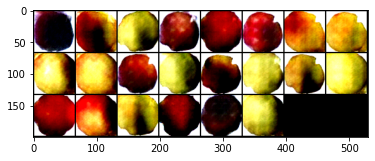

100%|██████████| 67/67 [00:25<00:00,  2.60it/s]


epoch: 14, lossD:1.2706840616553576, lossG:3.4519978637125956,lossG_fake:1.82353648054066, lossG_real:1.628461388509665 ,equality:0.19507509203099493


evaluate:42.87966537475586,kid_mean:0.02022767812013626, kid_std:0.010619535110890865,kid_:(tensor(0.0202), tensor(0.0106))


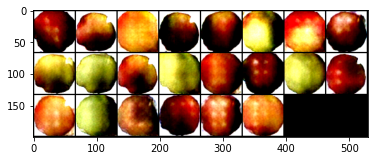

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 15, lossD:1.2739320566405112, lossG:3.5078073401949297,lossG_fake:1.8620721791217576, lossG_real:1.6457351746399012 ,equality:0.21633700448185644


evaluate:43.63214874267578,kid_mean:0.021603209897875786, kid_std:0.013536641374230385,kid_:(tensor(0.0216), tensor(0.0135))


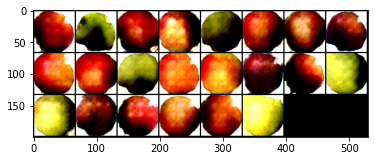

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 16, lossD:1.2129501380137544, lossG:3.491953173680092,lossG_fake:1.8304647705448207, lossG_real:1.6614884049145144 ,equality:0.16897636563030627


evaluate:46.46498107910156,kid_mean:0.024835117161273956, kid_std:0.015584233216941357,kid_:(tensor(0.0248), tensor(0.0156))


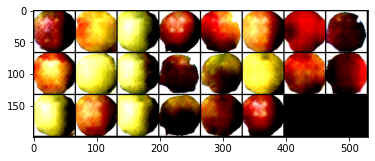

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 17, lossD:1.1899968705960173, lossG:3.6132798337224705,lossG_fake:1.8936766056872125, lossG_real:1.719603241824392 ,equality:0.17407336386282046


evaluate:45.99761199951172,kid_mean:0.02551848627626896, kid_std:0.01622147671878338,kid_:(tensor(0.0255), tensor(0.0162))


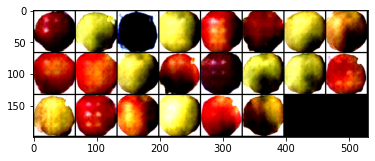

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 18, lossD:1.1614230186191958, lossG:3.6225110452566573,lossG_fake:1.9078312614070836, lossG_real:1.714679785184006 ,equality:0.1931514762230775


evaluate:47.10877990722656,kid_mean:0.023321472108364105, kid_std:0.015370129607617855,kid_:(tensor(0.0233), tensor(0.0154))


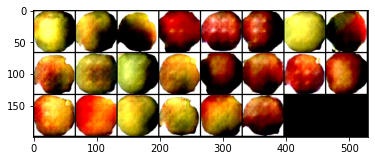

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 19, lossD:1.1908727839811524, lossG:3.6231974879307534,lossG_fake:1.8913014700163657, lossG_real:1.7318960143559015 ,equality:0.15940545566046427


evaluate:47.15946578979492,kid_mean:0.022842906415462494, kid_std:0.014367072843015194,kid_:(tensor(0.0228), tensor(0.0144))


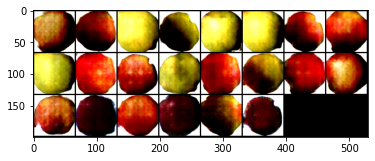

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 20, lossD:1.152519912862066, lossG:3.5685497219882794,lossG_fake:1.8446533377490826, lossG_real:1.723896369560441 ,equality:0.12075696818864157


evaluate:48.20828628540039,kid_mean:0.023124821484088898, kid_std:0.01606842502951622,kid_:(tensor(0.0231), tensor(0.0161))


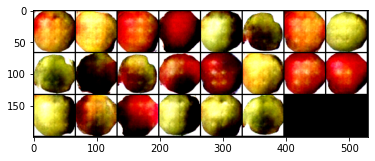

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 21, lossD:1.1106279928292802, lossG:3.6788166031908633,lossG_fake:1.9163924718081062, lossG_real:1.7624241247105954 ,equality:0.15396834709751084


evaluate:47.84520721435547,kid_mean:0.028269177302718163, kid_std:0.016959168016910553,kid_:(tensor(0.0283), tensor(0.0170))


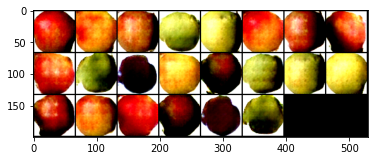

100%|██████████| 67/67 [00:26<00:00,  2.56it/s]


epoch: 22, lossD:1.06149204097577, lossG:3.8018368962985365,lossG_fake:2.0024931377439357, lossG_real:1.799343785243248 ,equality:0.20314935250068777


evaluate:46.464115142822266,kid_mean:0.024843189865350723, kid_std:0.016509562730789185,kid_:(tensor(0.0248), tensor(0.0165))


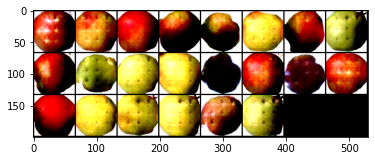

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 23, lossD:1.02345944740879, lossG:3.8359056408725567,lossG_fake:1.9850679422492412, lossG_real:1.8508376861686138 ,equality:0.13423025608062744


evaluate:46.38772201538086,kid_mean:0.0219748392701149, kid_std:0.01345448661595583,kid_:(tensor(0.0220), tensor(0.0135))


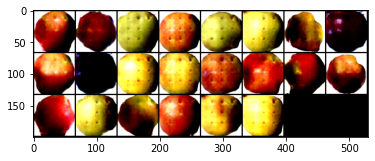

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 24, lossD:1.0505023825524458, lossG:3.8696818636424504,lossG_fake:2.045644939835392, lossG_real:1.8240369122419784 ,equality:0.22160802759341358


evaluate:46.254573822021484,kid_mean:0.02464313805103302, kid_std:0.01776101253926754,kid_:(tensor(0.0246), tensor(0.0178))


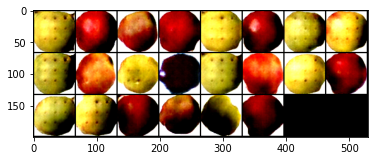

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 25, lossD:0.9608498842858556, lossG:3.9026242049772346,lossG_fake:2.040558909302327, lossG_real:1.8620652912267999 ,equality:0.17849361807552722


evaluate:46.79145431518555,kid_mean:0.02495444379746914, kid_std:0.016729509457945824,kid_:(tensor(0.0250), tensor(0.0167))


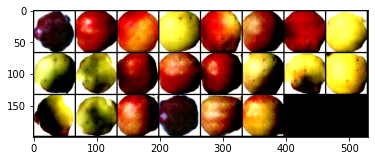

100%|██████████| 67/67 [00:26<00:00,  2.55it/s]


epoch: 26, lossD:0.9906393245084962, lossG:3.977839270634438,lossG_fake:2.0274279162065305, lossG_real:1.950411333966611 ,equality:0.07701658223991958


evaluate:47.52919387817383,kid_mean:0.02472052536904812, kid_std:0.013734746724367142,kid_:(tensor(0.0247), tensor(0.0137))


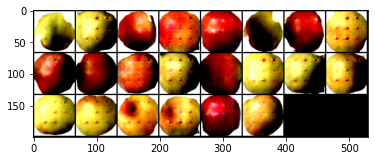

100%|██████████| 67/67 [00:26<00:00,  2.56it/s]


epoch: 27, lossD:0.889403919675457, lossG:4.040687617970936,lossG_fake:2.0930317969464545, lossG_real:1.947655814797131 ,equality:0.14537598214932346


evaluate:46.91503143310547,kid_mean:0.02600701153278351, kid_std:0.02057216502726078,kid_:(tensor(0.0260), tensor(0.0206))


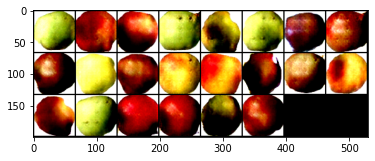

100%|██████████| 67/67 [00:26<00:00,  2.55it/s]


epoch: 28, lossD:0.9871378914633794, lossG:4.017813856921979,lossG_fake:2.1096470605081588, lossG_real:1.9081667910760909 ,equality:0.20148026943206787


evaluate:46.139041900634766,kid_mean:0.021609023213386536, kid_std:0.012249192222952843,kid_:(tensor(0.0216), tensor(0.0122))


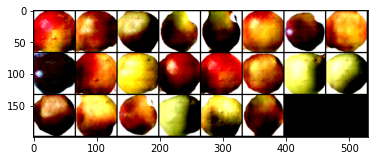

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 29, lossD:0.967255809413853, lossG:4.046042627363063,lossG_fake:2.0835842765978914, lossG_real:1.9624583445378203 ,equality:0.12112593206007105


evaluate:46.52634811401367,kid_mean:0.022841965779662132, kid_std:0.014813089743256569,kid_:(tensor(0.0228), tensor(0.0148))


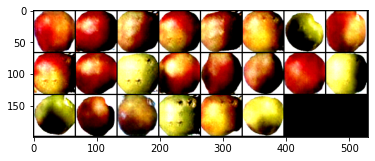

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 30, lossD:0.9357395817094775, lossG:3.9921088894801353,lossG_fake:2.0589840545583127, lossG_real:1.933124836256255 ,equality:0.1258592183020577


evaluate:46.54664611816406,kid_mean:0.02139684371650219, kid_std:0.01228319201618433,kid_:(tensor(0.0214), tensor(0.0123))


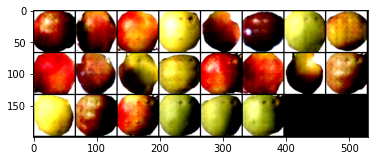

100%|██████████| 67/67 [00:26<00:00,  2.56it/s]


epoch: 31, lossD:0.8887874773189203, lossG:4.072290295985208,lossG_fake:2.1449260515953177, lossG_real:1.927364254175727 ,equality:0.2175617974195907


evaluate:46.03987121582031,kid_mean:0.023854393512010574, kid_std:0.015482015907764435,kid_:(tensor(0.0239), tensor(0.0155))


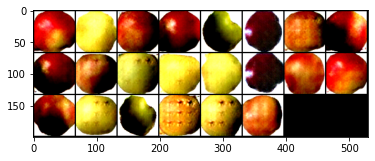

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 32, lossD:0.8368722360525558, lossG:4.210263006722749,lossG_fake:2.139584481716156, lossG_real:2.070678486752866 ,equality:0.06890599496328997


evaluate:46.39319610595703,kid_mean:0.02598434127867222, kid_std:0.0175733994692564,kid_:(tensor(0.0260), tensor(0.0176))


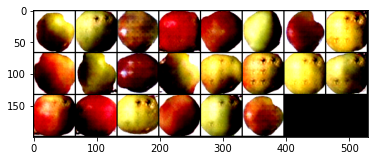

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 33, lossD:0.848607593507909, lossG:4.26008498846595,lossG_fake:2.2148994011665457, lossG_real:2.045185584630539 ,equality:0.1697138165360066


evaluate:46.1469612121582,kid_mean:0.024501128122210503, kid_std:0.014350821264088154,kid_:(tensor(0.0245), tensor(0.0144))


100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 34, lossD:0.9002990280069522, lossG:4.30840459154613,lossG_fake:2.2247650089548596, lossG_real:2.083639575474298 ,equality:0.14112543348056183


evaluate:45.5872917175293,kid_mean:0.022894246503710747, kid_std:0.015525417402386665,kid_:(tensor(0.0229), tensor(0.0155))


100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 35, lossD:0.8811543268054279, lossG:4.277903364665472,lossG_fake:2.2369668110093075, lossG_real:2.0409365670004886 ,equality:0.19603024400881885


evaluate:45.603633880615234,kid_mean:0.026320038363337517, kid_std:0.01704474724829197,kid_:(tensor(0.0263), tensor(0.0170))


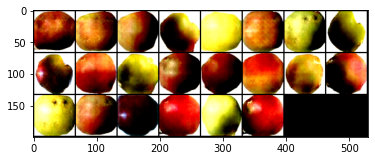

100%|██████████| 67/67 [00:25<00:00,  2.58it/s]


epoch: 36, lossD:0.7765220855154208, lossG:4.54174230703667,lossG_fake:2.313536666222473, lossG_real:2.2282056265802526 ,equality:0.08533103964222022


evaluate:45.317138671875,kid_mean:0.02381746843457222, kid_std:0.015993796288967133,kid_:(tensor(0.0238), tensor(0.0160))


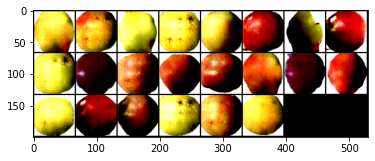

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 37, lossD:0.7948646798952302, lossG:4.469860379375628,lossG_fake:2.3054123520851135, lossG_real:2.164448033517866 ,equality:0.14096431856724756


evaluate:44.76847839355469,kid_mean:0.02277747355401516, kid_std:0.013141505420207977,kid_:(tensor(0.0228), tensor(0.0131))


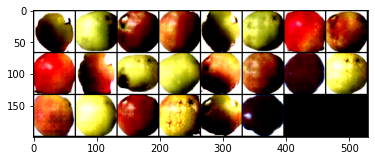

100%|██████████| 67/67 [00:26<00:00,  2.58it/s]


epoch: 38, lossD:0.8228164206245052, lossG:4.464854710137666,lossG_fake:2.318673092037884, lossG_real:2.1461816123172417 ,equality:0.17249147972064227


evaluate:43.86591339111328,kid_mean:0.02365468069911003, kid_std:0.01307121105492115,kid_:(tensor(0.0237), tensor(0.0131))


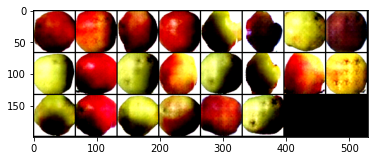

100%|██████████| 67/67 [00:26<00:00,  2.55it/s]


epoch: 39, lossD:0.6188460862013831, lossG:4.768869602858131,lossG_fake:2.4558802166981484, lossG_real:2.3129893728156588 ,equality:0.14289084388248963


evaluate:43.271507263183594,kid_mean:0.021769223734736443, kid_std:0.014264276251196861,kid_:(tensor(0.0218), tensor(0.0143))


100%|██████████| 67/67 [00:25<00:00,  2.58it/s]


epoch: 40, lossD:0.7214647809516138, lossG:4.638646930011351,lossG_fake:2.4116023787811622, lossG_real:2.2270445352170003 ,equality:0.18455784356416194


evaluate:43.36048889160156,kid_mean:0.02281000092625618, kid_std:0.01812371239066124,kid_:(tensor(0.0228), tensor(0.0181))


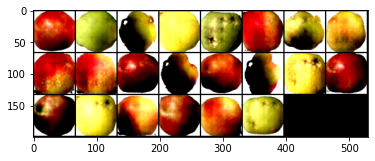

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 41, lossD:0.6768587874387627, lossG:4.686909668481172,lossG_fake:2.4767122037375153, lossG_real:2.2101974763087373 ,equality:0.266514727428778


evaluate:42.79376220703125,kid_mean:0.02255323715507984, kid_std:0.015510893426835537,kid_:(tensor(0.0226), tensor(0.0155))


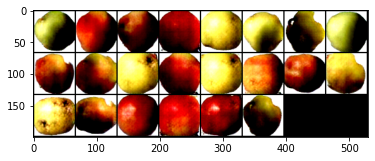

100%|██████████| 67/67 [00:26<00:00,  2.57it/s]


epoch: 42, lossD:0.7059939771668234, lossG:4.667166937643023,lossG_fake:2.3842946495582806, lossG_real:2.2828722889743633 ,equality:0.10142236058391729


evaluate:42.50978469848633,kid_mean:0.022148780524730682, kid_std:0.018210258334875107,kid_:(tensor(0.0221), tensor(0.0182))


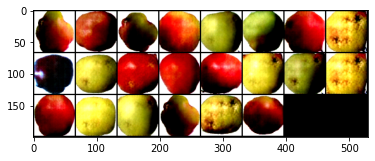

100%|██████████| 67/67 [00:25<00:00,  2.58it/s]


epoch: 43, lossD:0.5635740829270277, lossG:4.973252680764269,lossG_fake:2.586187008601516, lossG_real:2.3870656819485907 ,equality:0.19912132665292548


evaluate:42.53744125366211,kid_mean:0.02072576992213726, kid_std:0.01464548334479332,kid_:(tensor(0.0207), tensor(0.0146))


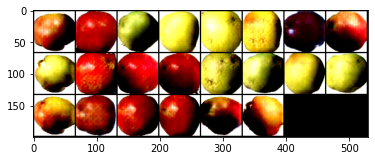

100%|██████████| 67/67 [00:25<00:00,  2.58it/s]


epoch: 44, lossD:0.7813172989816808, lossG:4.763763904571533,lossG_fake:2.5134562440772554, lossG_real:2.250307694299897 ,equality:0.26314854977735846


evaluate:42.568016052246094,kid_mean:0.02134690061211586, kid_std:0.014301799237728119,kid_:(tensor(0.0213), tensor(0.0143))


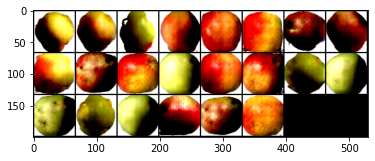

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 45, lossD:0.6278874325885702, lossG:4.817612085769426,lossG_fake:2.506340464549278, lossG_real:2.31127163411966 ,equality:0.19506883042961798


evaluate:42.915748596191406,kid_mean:0.022885534912347794, kid_std:0.014231396839022636,kid_:(tensor(0.0229), tensor(0.0142))


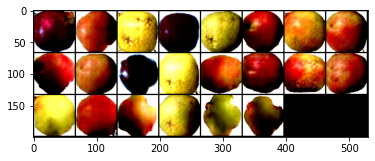

100%|██████████| 67/67 [00:26<00:00,  2.56it/s]


epoch: 46, lossD:0.5285145675958093, lossG:5.046759206857255,lossG_fake:2.604858843248282, lossG_real:2.4419003751740527 ,equality:0.1629584680742293


evaluate:42.60293960571289,kid_mean:0.01996004581451416, kid_std:0.010171140544116497,kid_:(tensor(0.0200), tensor(0.0102))


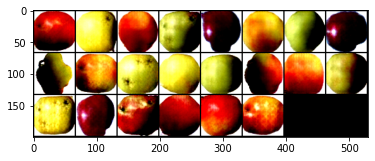

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 47, lossD:0.537037527939277, lossG:4.975654986367297,lossG_fake:2.5973194303797253, lossG_real:2.378335574224814 ,equality:0.21898385615491156


evaluate:42.3996467590332,kid_mean:0.022184941917657852, kid_std:0.015176983550190926,kid_:(tensor(0.0222), tensor(0.0152))


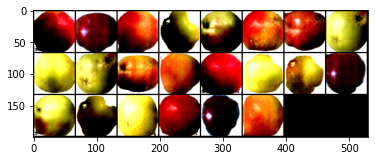

100%|██████████| 67/67 [00:25<00:00,  2.59it/s]


epoch: 48, lossD:0.5706473498869298, lossG:5.131180499916646,lossG_fake:2.655962188742054, lossG_real:2.475218290713296 ,equality:0.18074389802875812


evaluate:42.05218505859375,kid_mean:0.022316157817840576, kid_std:0.015013666823506355,kid_:(tensor(0.0223), tensor(0.0150))


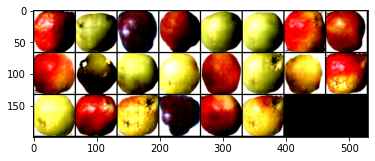

100%|██████████| 67/67 [00:26<00:00,  2.58it/s]


epoch: 49, lossD:0.5622441674123949, lossG:5.055603981018066,lossG_fake:2.6350594803468503, lossG_real:2.4205445260254304 ,equality:0.21451495432141998


evaluate:42.27669906616211,kid_mean:0.02144801802933216, kid_std:0.014482921920716763,kid_:(tensor(0.0214), tensor(0.0145))


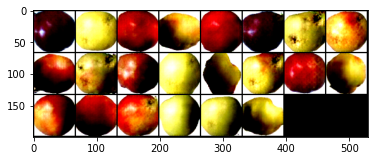

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

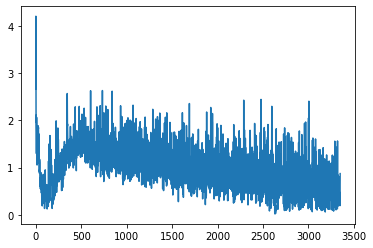

In [45]:
plt.plot(raw_lossesD)

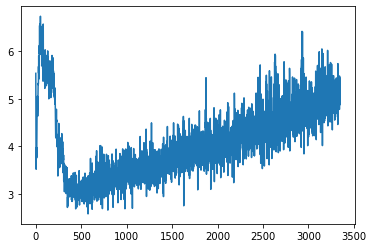

In [46]:
plt.plot(raw_lossesG)

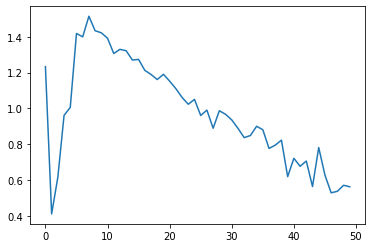

In [47]:
plt.plot(lossesD)

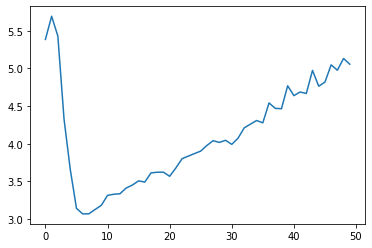

In [48]:
plt.plot(lossesG)

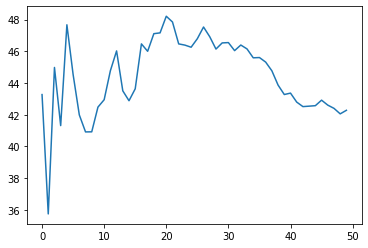

In [49]:
plt.plot(fid_)

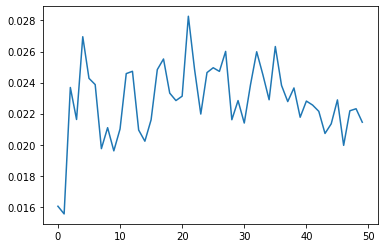

In [50]:
plt.plot(kid_mean_)

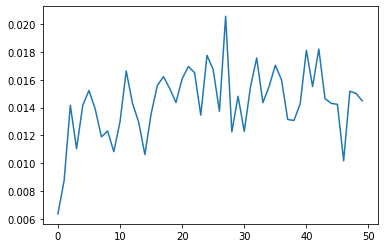

In [51]:
plt.plot(kid_std_)

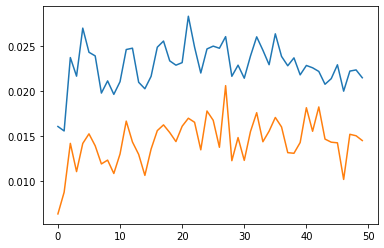

In [52]:
plt.plot(kid_score)

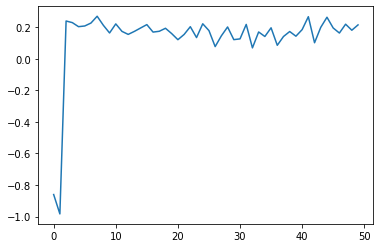

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0206), tensor(0.0133))